# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/DBS_studies_influencing_memory/metadata/master_list.csv'
sheet = None #'master_list_proper_subjects' ?

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_10/weighted_map_flipped_lesions'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_target_in_subject_y']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
data_df.columns

In [ ]:
column = 'Disease'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'Parkinson' # The value to compare against

In [ ]:
# data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

Regress out a Covariate

In [ ]:
data_df.columns

In [ ]:
for col in regressors:
    if data_df[col].dtype == 'O':  # object/categorical
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  # numeric
        data_df[col] = data_df[col].fillna(data_df[col].mean())
data_df[regressors].isna().sum()


In [122]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
dependent_variable_list = ['Pre_Post_Memory_Effect_Size__Cohen_s_D_']
regressors = ['Disease', 'Years_Between_Measurements', 'Mean_Age', 'Frequency__Hz_']

data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)


 Formula for Pre_Post_Memory_Effect_Size__Cohen_s_D_: 
 Pre_Post_Memory_Effect_Size__Cohen_s_D_ ~ Disease + Years_Between_Measurements + Mean_Age + Frequency__Hz_
['Pre_Post_Memory_Effect_Size__Cohen_s_D__residual']


In [123]:
import numpy as np

nonzero_count = np.count_nonzero(data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D__residual'])
not_nan_count = data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D__residual'].notna().sum()
print(f"Nonzero count: {nonzero_count}")
print(f"Non-NaN count: {not_nan_count}")

Nonzero count: 98
Non-NaN count: 30


**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Misc Filtering

In [128]:
data_df = data_df[data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'].abs() <= 1.0]
data_df

,study,Memory_Specific,ses,N,Memory_Outcome,Pre_Post_Memory_Effect_Size__Cohen_s_D_,Location,List_of_Coordinates,Side,Frequency__Hz_,...,all_datasets_weighted_avg_r_map_average_subject_in_target,all_datasets_weighted_avg_r_map_average_target_in_subject,all_datasets_weighted_avg_r_map_num_in_roi,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_spatial_corr_y,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_cosine_y,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_sum_y,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_subject_in_target_y,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_target_in_subject_y,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_num_in_roi_y,Pre_Post_Memory_Effect_Size__Cohen_s_D__residual
0,Acera 2019,0.0,STN_BL,50.0,Impaired,-0.180960,STN,"[14.2, -15.1, -6.1], [-13.5, -14.2, -6.1]",BL,NaN,...,9.502533e-08,0.005730,0.0,0.000885,0.000892,0.164717,1.077068e-06,0.082359,0.0,NaN
1,Asahi 2014,0.0,STN_BL,11.0,Improved,0.234145,STN,"[-16.7, -6.0, -1.7], [18.6, -5.3, -1.7]",BL,130.0,...,-1.419487e-06,-0.085595,0.0,-0.000440,-0.000434,-0.080103,-5.237877e-07,-0.040052,0.0,1.637579e-15
3,Bergfeld 2017,0.0,vALIC_BL,20.0,Impaired,-0.688208,vALIC,"[-11.6, 7.2, -3.2], [12.7, 8.7, -2.4]",BL,140.0,...,-2.479925e-07,-0.014954,0.0,0.000426,0.000432,0.079793,5.217602e-07,0.039897,0.0,NaN
5,Cabrera-Montes 2025,0.0,STN_BL,20.0,Impaired,-0.142554,STN,"[-16.7, -6.0, -1.7], [18.6, -5.3, -1.7]",BL,130.0,...,-1.419487e-06,-0.085595,0.0,-0.000440,-0.000434,-0.080103,-5.237877e-07,-0.040052,0.0,2.386980e-15
6,Coleshill 1990,1.0,HPC_L,6.0,Improved,0.060798,HPC,"[-28.9, -24.5, -14.2]",L,50.0,...,-8.714673e-07,-0.105099,0.0,-0.003496,-0.003491,-0.456027,-2.981914e-06,-0.456027,0.0,2.539796e-02
7,Coleshill 1990,1.0,HPC_L,6.0,Improved,0.199356,HPC,"[-28.9, -24.5, -14.2]",L,50.0,...,-8.714673e-07,-0.105099,0.0,-0.003496,-0.003491,-0.456027,-2.981914e-06,-0.456027,0.0,1.639566e-01
8,Coleshill 1990,1.0,HPC_L,6.0,Improved,0.249413,HPC,"[-28.9, -24.5, -14.2]",L,50.0,...,-8.714673e-07,-0.105099,0.0,-0.003496,-0.003491,-0.456027,-2.981914e-06,-0.456027,0.0,2.140129e-01
9,Coleshill 1990,1.0,HPC_R,6.0,Impaired,-0.374855,HPC,"[28.9, -24.5, -14.2]",R,50.0,...,-1.042630e-06,-0.125741,0.0,-0.003870,-0.003865,-0.504926,-3.301660e-06,-0.504926,0.0,-4.102549e-01
10,Coleshill 1990,1.0,HPC_R,6.0,Impaired,-0.173749,HPC,"[28.9, -24.5, -14.2]",R,50.0,...,-1.042630e-06,-0.125741,0.0,-0.003870,-0.003865,-0.504926,-3.301660e-06,-0.504926,0.0,-2.091487e-01
11,Coleshill 1990,1.0,HPC_R,6.0,Improved,0.251436,HPC,"[28.9, -24.5, -14.2]",R,50.0,...,-1.042630e-06,-0.125741,0.0,-0.003870,-0.003865,-0.504926,-3.301660e-06,-0.504926,0.0,2.160361e-01


# 02 - Perform Basic Correlation

In [129]:
data_df.columns

Index(['study', 'Memory_Specific', 'ses', 'N', 'Memory_Outcome',
       'Pre_Post_Memory_Effect_Size__Cohen_s_D_', 'Location',
       'List_of_Coordinates', 'Side', 'Frequency__Hz_', 'Magnitude__V_',
       'Pulse_Width__us_', 'Continuous', 'Encoding_Stim', 'Consolidation_Stim',
       'Recall_Stim', 'Closed_Loop', 'Years_Between_Measurements', 'Mean_Age',
       'Percent_Female', 'Disease', 'Test', 'Recall_Subtype', 'Sensory_Domain',
       'Control_Group', 'Notes', 'pooled_stdev', 'experimental_baseline_mean',
       'experimental_baseline_stdev', 'N_1', 'Unnamed__29',
       'experimental_post_mean', 'experimental_post_stdev',
       'experimental_post_n', 'path',
       'all_datasets_weighted_avg_r_map_inverted_spatial_corr',
       'all_datasets_weighted_avg_r_map_inverted_cosine',
       'all_datasets_weighted_avg_r_map_inverted_sum',
       'all_datasets_weighted_avg_r_map_inverted_average_subject_in_target',
       'all_datasets_weighted_avg_r_map_inverted_average_target_in_sub

In [165]:
x_col = 'all_datasets_weighted_avg_r_map_pcc_inverse_r_map_num_in_roi_y'
y_col = 'Pre_Post_Memory_Effect_Size__Cohen_s_D_'

/Users/cu135/Software_Local/calvin_utils_project/calvin_utils_project/calvin_utils/statistical_utils/scatterplot.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(x_vals, y_vals, nan_policy='omit')
/Users/cu135/Software_Local/calvin_utils_project/calvin_utils_project/calvin_utils/statistical_utils/scatterplot.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pr = pearsonr(x_vals, y_vals)


<Figure size 432x432 with 0 Axes>

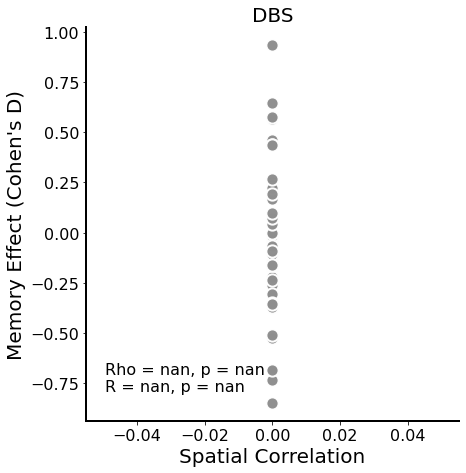

In [166]:
from calvin_utils.statistical_utils.scatterplot import simple_scatter
simple_scatter(data_df, x_col, y_col, 'DBS', 
               x_label="Spatial Correlation",
               y_label='Memory Effect (Cohen\'s D)',
               out_dir=out_dir, flip_axes=False)

In [ ]:
out_dir

# Correlate Variable with All Other Variables

In [169]:
x_col = 'Pre_Post_Memory_Effect_Size__Cohen_s_D_'

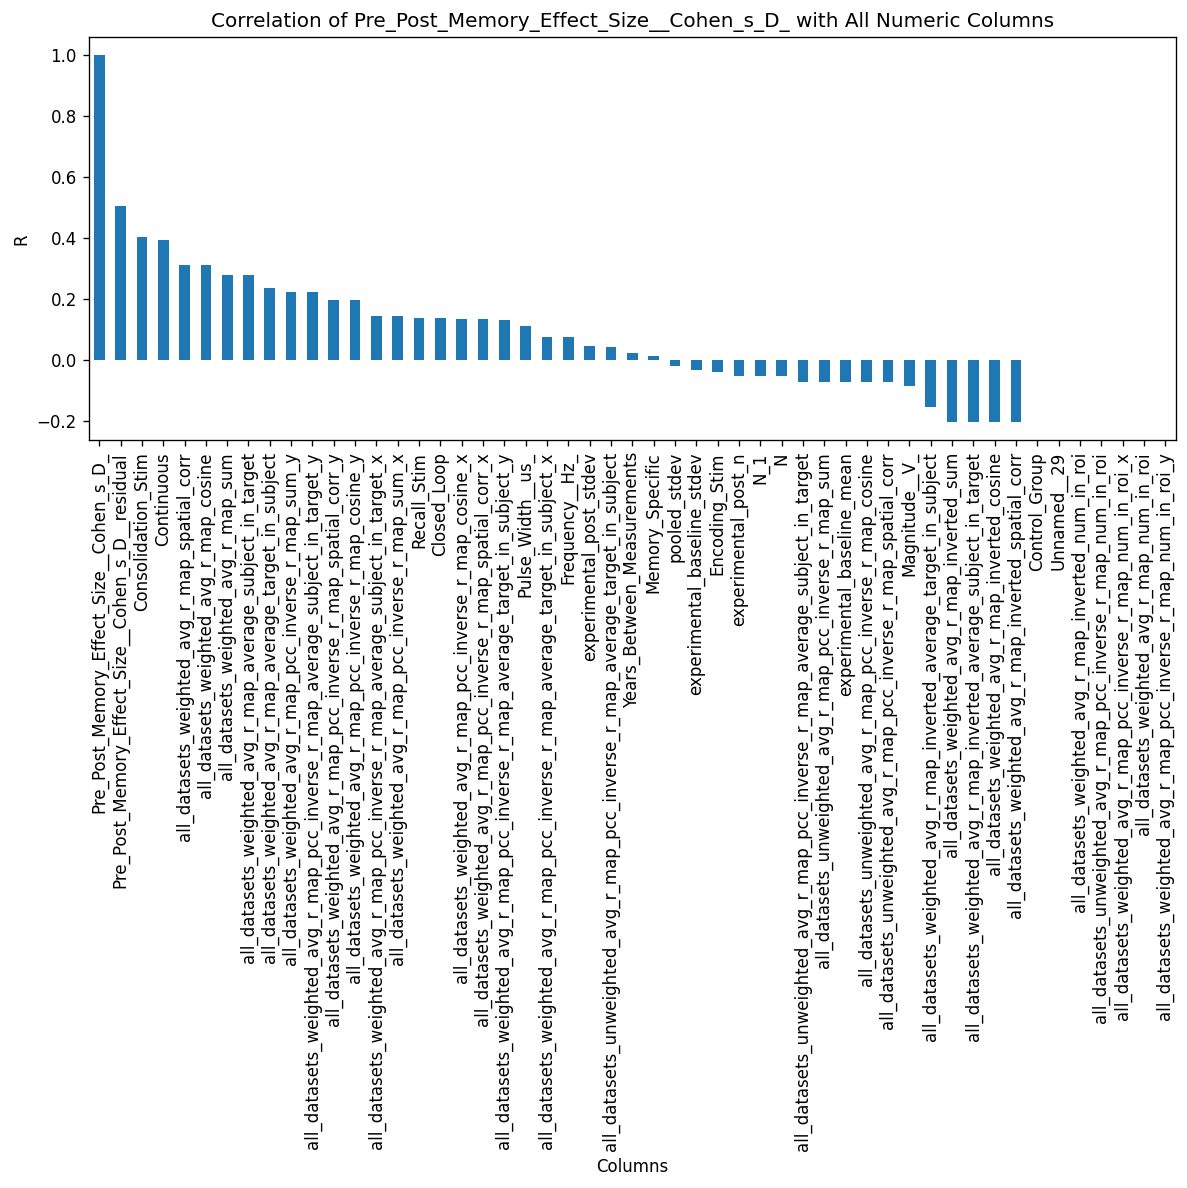

In [170]:
from calvin_utils.statistical_utils.correlation_barplot import CorrelationBarPlot
plotter = CorrelationBarPlot(data_df, x_col=x_col, method="spearman")
corr_series = plotter.run(save_path=None)

Focus on correlations above a threhsold

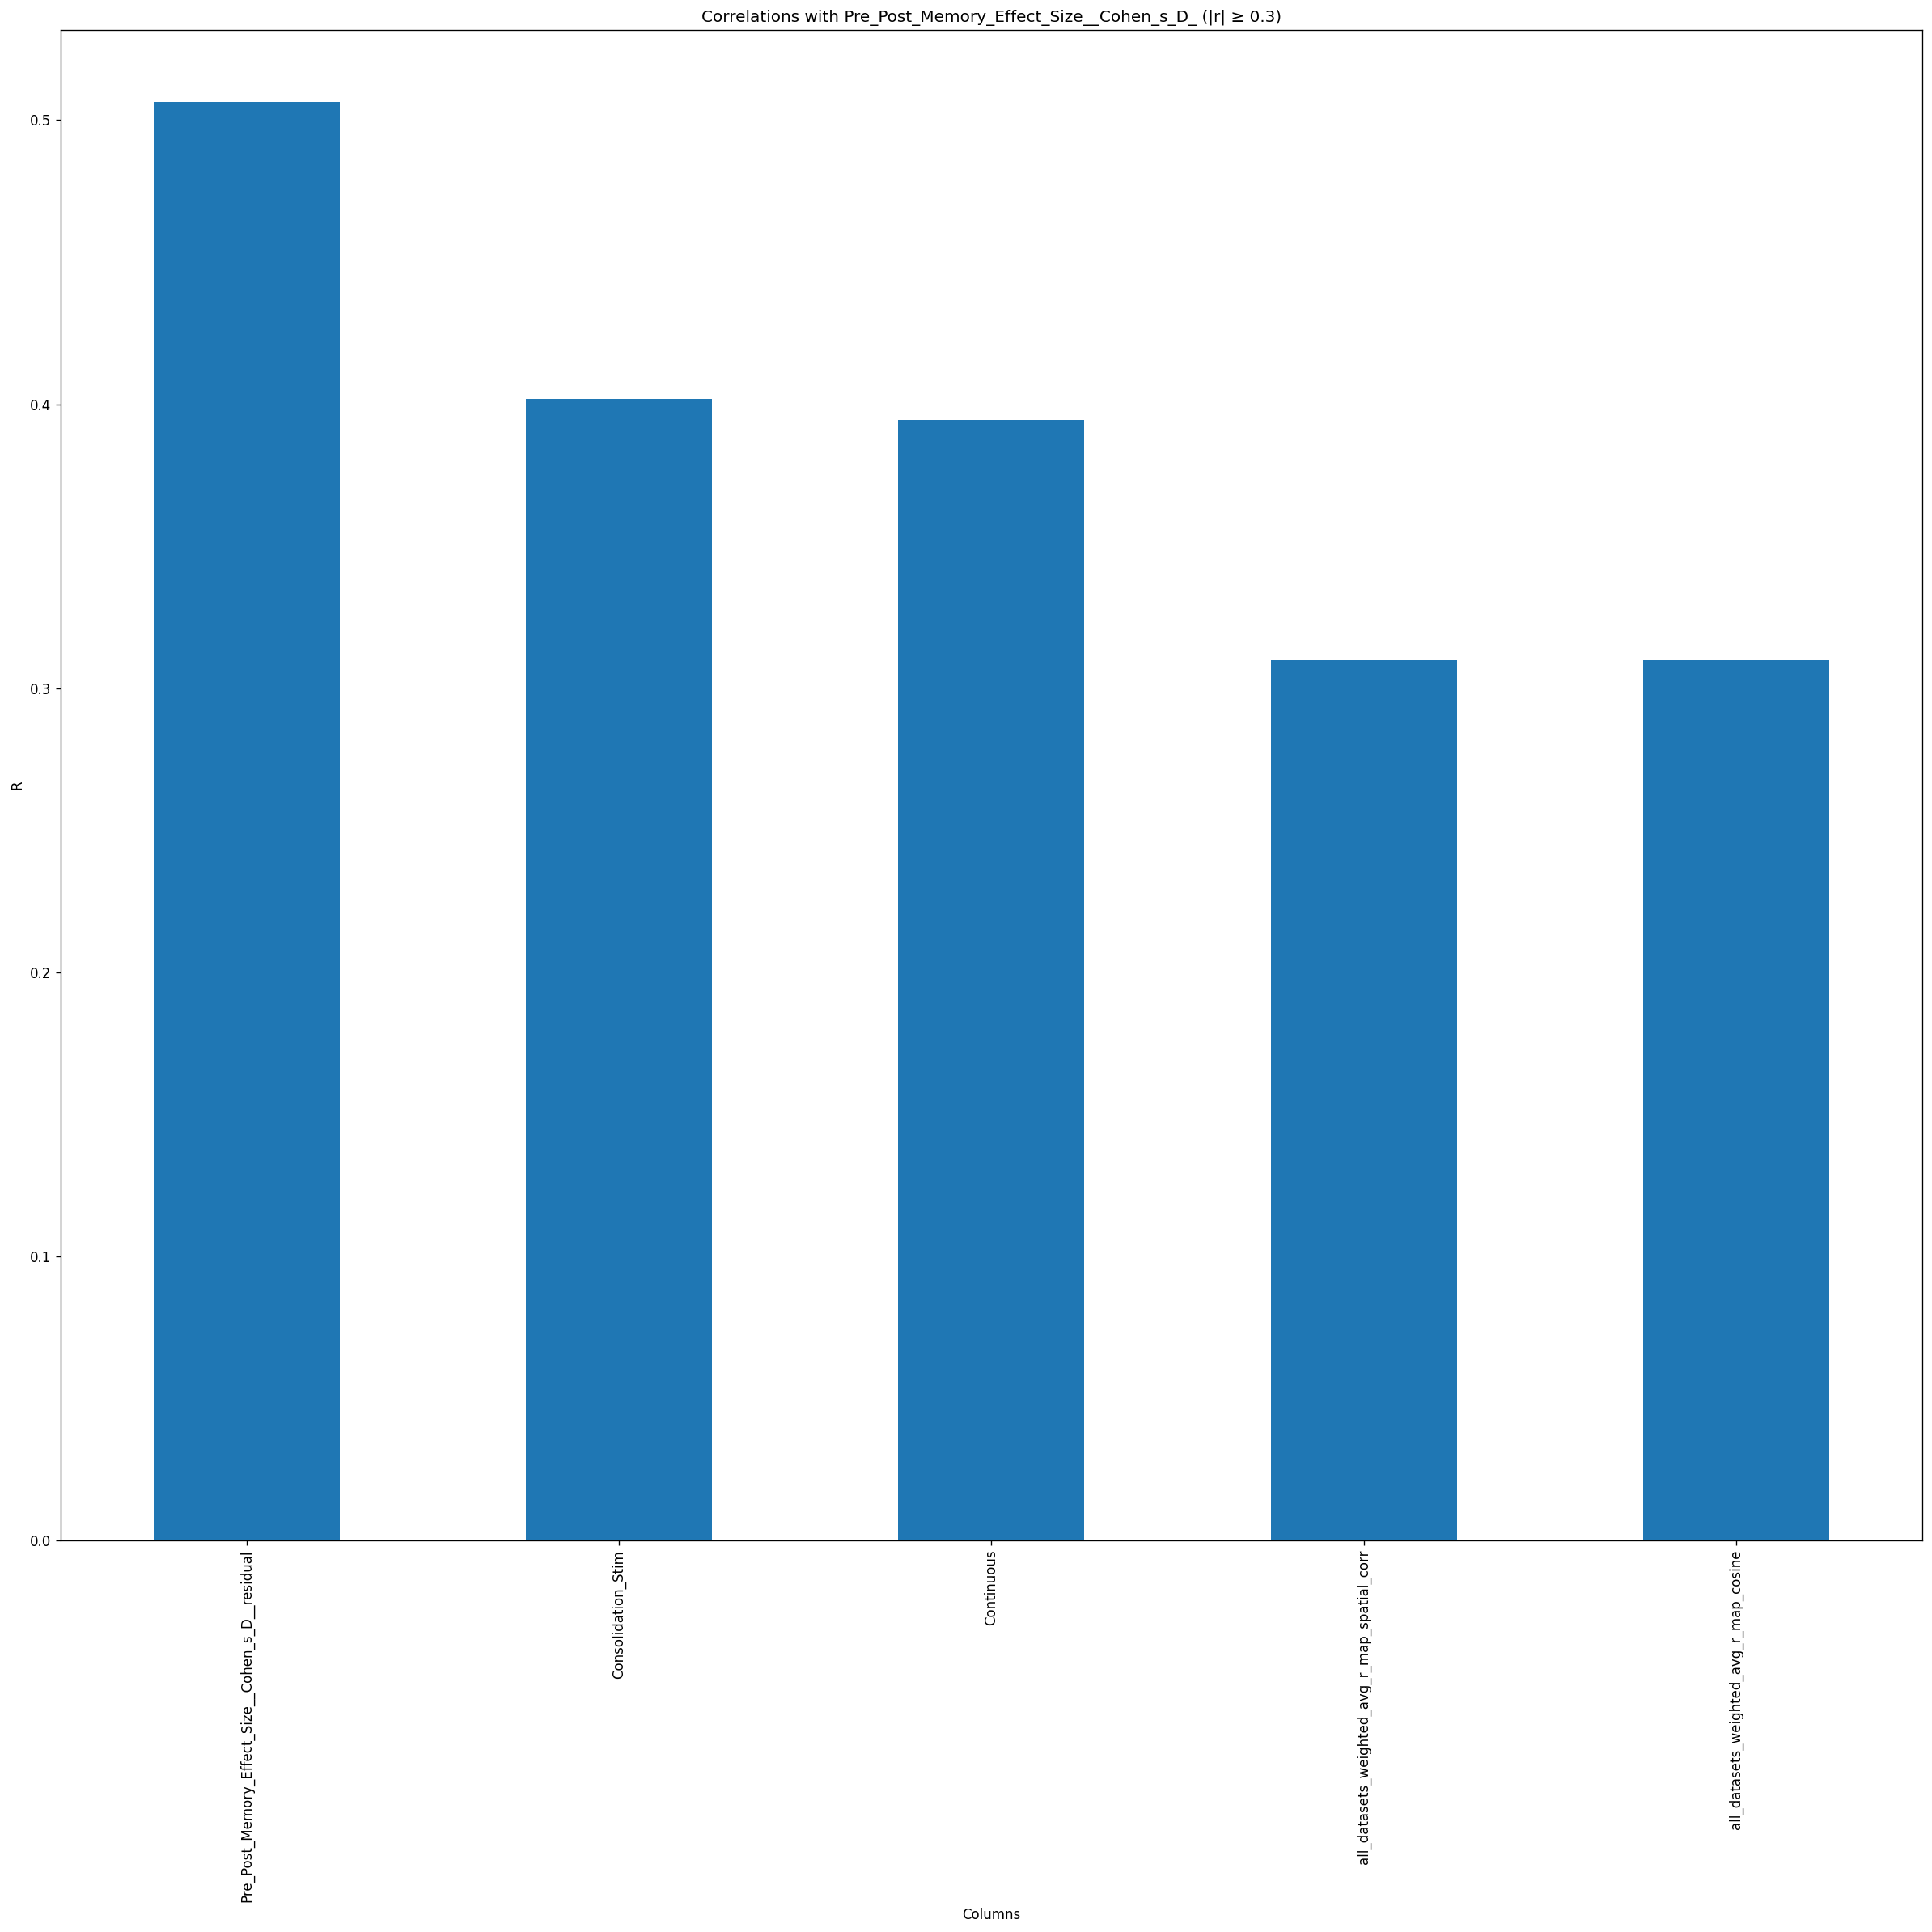

In [172]:
strong_corrs = plotter.plot_threshold(0.3)      # |r| ≥ 0.4 plot